In [1]:
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')
import numpy as np
from astrometry.util.fits import *
import pylab as plt

In [2]:
import sys
sys.path.insert(0, '/global/homes/d/dstn/.local/lib/python3.6/site-packages')
import astropy
print(astropy.__file__)

/global/homes/d/dstn/.local/lib/python3.6/site-packages/astropy/__init__.py


In [3]:
sys.version

'3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) \n[GCC 7.3.0]'

In [4]:
'''
Pointing offsets are computed in lines 754 to 769.

"tan" is tan(zenith-distance)
"psi" is parallactic angle (same as is displayed in the control room).
"DEG2RAD" is pi/180.

"polyeval" is a function that evaluates a polynomial.

The coefficients are stored as a list of numbers in "xoffcoeff()" and
"yoffcoeff()"  The polynomial turns out to be 4th order.

The numerical values for the pointing offset coeffs are here:

https://desi.lbl.gov/trac/browser/code/online/DervishTools/trunk/desi/etc/desi/xoffcoeff.par
https://desi.lbl.gov/trac/browser/code/online/DervishTools/trunk/desi/etc/desi/yoffcoeff.par

The units are arcmin.
''';

In [5]:
'''
set tan [expr tan($zd*$DEG2RAD)]
...
#Focal plane center.  I will invent two global storage elements, although
#I don't use  them anywhere
   global xoffcoeff yoffcoeff scalecoeff rotcoeff
   global xoffth yoffth scaleth rotth
   if {[info exists xoffth]} {unset xoffth}
   if {[info exists yoffth]} {unset yoffth}
   if {[info exists scaleth]} {unset scaleth}
   if {[info exists rotth]} {unset rotth}
   set xoffth0 [polyeval $tan $xoffcoeff()]
   set yoffth0 [polyeval $tan $yoffcoeff()]

#These rotate with the parallactic angle
   set cs [expr cos($psi*$DEG2RAD)]
   set sn [expr sin($psi*$DEG2RAD)]
   set xoffth [expr $xoffth0*$cs - $yoffth0*$sn]
   set yoffth [expr $yoffth0*$cs + $xoffth0*$sn]
''';

In [6]:
'''
proc polyeval {xlist coefflist} {
   set ylist ""
   loop i 0 [llength $xlist] {
	set comp 0.
	set x [lindex $xlist $i]
	loop j 0 [llength $coefflist] {
	   set comp [expr $comp + [lindex $coefflist $j]*pow($x,$j)]
	   }
	lappend ylist $comp
	}
   return $ylist
   }
''';

In [7]:
'''
The angles for the adc are computed in lines 774 to 806.
There are two angles, one for each element of the ADC.
Ultimately, it is another polynomial, this one second order.

The numerical values for the adc coeffs are here:
https://desi.lbl.gov/trac/browser/code/online/DervishTools/trunk/desi/etc/desi/PRISM.par

The coefficients evaluate to radians, which are converted to degrees
before being stored.



set tan [expr tan($zd*$DEG2RAD)]
       foreach id $PRISM() {
	set nterm [llength $PRISM($id)]
	set coefflist ""
	set x $tan
	if {$nterm > 3} {
	   set x [expr sqrt($x)]
	   }
	foreach var $PRISM($id) {
	   lappend coefflist $PRISM($id,$var)
	   }
	lappend adc() $id

#Note that coefflist returns phi in radians.  Normally I want degrees.
	set adc($id) [expr [polyeval $x $coefflist]/$DEG2RAD]

#Add in parallactic angle
	set adc($id) [expr $adc($id) + $psi]

#Range is 0 to 360
	if {$adc($id) < 0.} {set adc($id) [expr $adc($id) + 360.]}
	if {$adc($id) >= 360.} {set adc($id) [expr $adc($id) - 360.]}
	}

#For provenance tracking, I will cache the input zd and psi in the adc
#array
   set adc(zd) $zd
   set adc(psi) $psi
''';

In [8]:
def cosd(d):
    return np.cos(np.deg2rad(d))
def sind(d):
    return np.sin(np.deg2rad(d))
def tand(d):
    return np.tan(np.deg2rad(d))

In [9]:
xoffcoeff = np.array([2.0757544727934544e-06, -0.007961331238163066, 0.0056061248311369436,
             0.0018986691756501632, -0.0013070691347911939])
yoffcoeff = np.array([-3.4502816243324724e-05, 0.47349367638360584, 0.21307640716964973,
             0.037039201803243993, -0.055050297665415526])

In [10]:
def polyeval(t, coeffs):
    '''
    t: 1-d vector
    '''
    #print(t.shape)
    #print(coeffs.shape)
    nc = len(coeffs)
    return np.sum(t[:,np.newaxis]**np.arange(nc)[np.newaxis,:] * coeffs, axis=1)

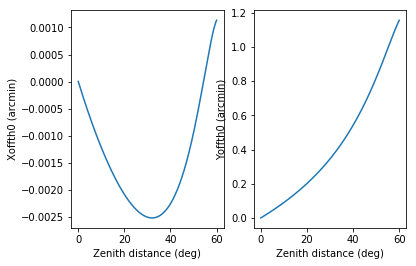

In [11]:
zd = np.linspace(0,60, 300)
plt.subplot(1,2,1)
plt.plot(zd, polyeval(tand(zd), xoffcoeff))
plt.xlabel('Zenith distance (deg)')
plt.ylabel('Xoffth0 (arcmin)');
plt.subplot(1,2,2)
plt.plot(zd, polyeval(tand(zd), yoffcoeff))
plt.xlabel('Zenith distance (deg)')
plt.ylabel('Yoffth0 (arcmin)');

In [12]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, AltAz
from astropy.coordinates import EarthLocation
from astropy import units as u
from astropy.utils import iers
#iers.conf.auto_download = False

In [13]:
gfaexptime = 10.
specexptime = 1200.
overheadtime = 120.

In [77]:
from math import fmod
from numpy import sin, cos, degrees, radians, arctan2, arcsin, arccos, tan

def kent_wrap_at(angle, wrap_angle):
    """Wrap angle so it falls between wrap_angle - 360 and wrap_angle.

    Args:
        angle: an angle in degrees
        wrap_angle: the max (exclusive) angle the wrapped rep. should take

    Returns:
        the wrapped angle
    """
    if abs(wrap_angle) > 360:
        raise NotImplementedError

    wrapped = angle % 360
    if wrapped < wrap_angle:
        wrapped += 360.0

    if wrapped >= wrap_angle:
        wrapped -= 360.0

    return wrapped

def kent_sidereal_time(mjd, longitude):
    """Local Sidereal Time at an mjd and longitude.

    This calculation ignore precession and nutation, and it's precesion
    is limited to ~10 asec.

    There is a "drop in" alternative implemented using astropy in
    astron_ap.sidereal_time.

    Args:
        mjd: MJD in days
        longitude: longitude in degrees, positive West

    Returns:
        sidereal time in degrees

    """
    # lst0 is LST at longitude = 0
    lst0 = 360*fmod(mjd+(mjd-52903.54875)*(366.24125/365.24125-1.0), 1)
    st = kent_wrap_at(lst0 - longitude, 360)
    return st

def kent_zenith_distance(ha, decl, latitude):
    """Calculate LST, HA, and zenith distance.

    Args:
        ha: hour angle in decimal degrees
        decl: declination in decimal degrees
        latitude: in degrees

    Returns:
        zenith distance in decimal degrees

    """
    rha = radians(ha)
    rdecl = radians(decl)
    rphi = radians(latitude)

    rzd = arccos(cos(rha) * cos(rdecl) * cos(rphi) + sin(rdecl) * sin(rphi))
    zd = degrees(rzd)

    return zd

def kent_parallactic_angle(ha, decl, latitude):
    """Calculate the parallactic angle.

    Args:
        ha: Hour Angle (decimal degrees)
        decl: declination (decimal degrees)
        latitude: in decimas degrees

    Returns:
        the parallactic angle in decimal degrees

    """
    rha = radians(ha)
    rdecl = radians(decl)
    rphi = radians(latitude)

    rpsi = -1 * arctan2(sin(rha)*cos(rphi),
                        cos(rdecl)*sin(rphi) - sin(rdecl)*cos(rphi)*cos(rha))
    psi = degrees(rpsi)
    return psi


In [84]:
def compute(dname):
    Da = fits_table('~/desi-commish/%sa.fits' % dname)
    Db = fits_table('~/desi-commish/%sb.fits' % dname)
    D = merge_tables([Da, Db])
    #dname = 'dither2'

    #site = EarthLocation.of_site('kpno')
    site = EarthLocation.from_geodetic(-111.59989 * u.deg, 31.96403 * u.deg, 2097.)
    D.kent_zd = np.zeros(len(D))
    D.redo_zd = np.zeros(len(D))
    D.kent_parallactic = np.zeros(len(D))
    for i,d in enumerate(D):
        #time = Time(d.mjd, format='mjd', scale='tai')
        #off = (d.exptime / 2.) / (3600.*24.)
        off = 0.
        #time = Time(d.mjd + off, format='mjd', scale='ut1')
        time = Time(d.mjd + off, format='mjd', scale='utc')

        offset = (overheadtime + gfaexptime + specexptime/2.) / (3600.*24.)
        kent_mjd = d.mjd + offset
        kent_time = Time(d.mjd + offset, format='mjd', scale='utc')

        coords = SkyCoord(d.sky_ra, d.sky_dec, unit='deg')
        altaz = coords.transform_to(AltAz(obstime=time, location=site))
        zd = 90. - altaz.alt.to_value(unit=u.deg)
        print('ZD', zd, 'vs', d.zd)
        D.redo_zd[i] = zd

        # from PlateMaker/desi.dat
        longitude = 111.6003
        latitude = 31.9634

        lst = kent_sidereal_time(kent_mjd, longitude)
        ha = kent_wrap_at(lst - d.sky_ra, 180)
        zd = kent_zenith_distance(ha, d.sky_dec, latitude)
        D.kent_zd[i] = zd
        D.kent_parallactic[i] = -kent_parallactic_angle(ha, d.sky_dec, latitude)
        #kent_altaz = coords.transform_to(AltAz(obstime=kent_time, location=site))
        #D.kent_zd[i] = 90. - kent_altaz.alt.to_value(unit=u.deg)
        
    
    #tan = tand(D.zd)
    tan = tand(D.kent_zd)

    parallactic = D.kent_parallactic
    
    xoffth0 = polyeval(tan, xoffcoeff)
    yoffth0 = polyeval(tan, yoffcoeff)
    cs = cosd(parallactic)
    sn = sind(parallactic)
    D.xoffth = xoffth0 * cs - yoffth0 * sn
    D.yoffth = yoffth0 * cs + xoffth0 * sn

    adc1coeffs = [-0.0008, -0.3981, -0.1897]
    adc2coeffs = [0.0361, 0.3586, 0.2010]
    adc1 = np.rad2deg(polyeval(tan, adc1coeffs)) + parallactic
    adc2 = np.rad2deg(polyeval(tan, adc2coeffs)) + parallactic
    adc1 += (adc1 < 0.)*360.
    adc2 += (adc2 < 0.)*360.
    D.adc1 = adc1
    D.adc2 = adc2
    return D

ZD 28.32913942915659 vs 28.235773
ZD 28.186069865217164 vs 28.091393
ZD 28.03937291419124 vs 27.942957
ZD 27.87776388679636 vs 27.782293
ZD 27.73458764839284 vs 27.638945
ZD 27.593241485184627 vs 27.498494
ZD 27.450044112794437 vs 27.354499
ZD 27.291399414753712 vs 27.195556
ZD 27.145323051058888 vs 27.05049
ZD 26.999623879606503 vs 26.905603
ZD 26.853554652098993 vs 26.757682
ZD 26.712294262488868 vs 26.614133
ZD 26.57624497138309 vs 26.475079
ZD 26.435545170867925 vs 26.333922
ZD 26.291740170084807 vs 26.194188
ZD 26.140057247015562 vs 26.038635
ZD 26.004196443503723 vs 25.903526
ZD 25.867523406500183 vs 25.766648
ZD 25.727212092324734 vs 25.62883
ZD 25.569308280959035 vs 25.471754
ZD 25.427409049234583 vs 25.326734
ZD 25.291335753842887 vs 25.18949


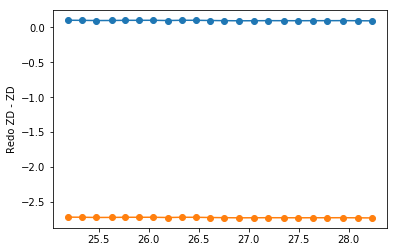

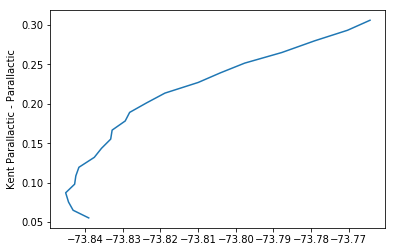

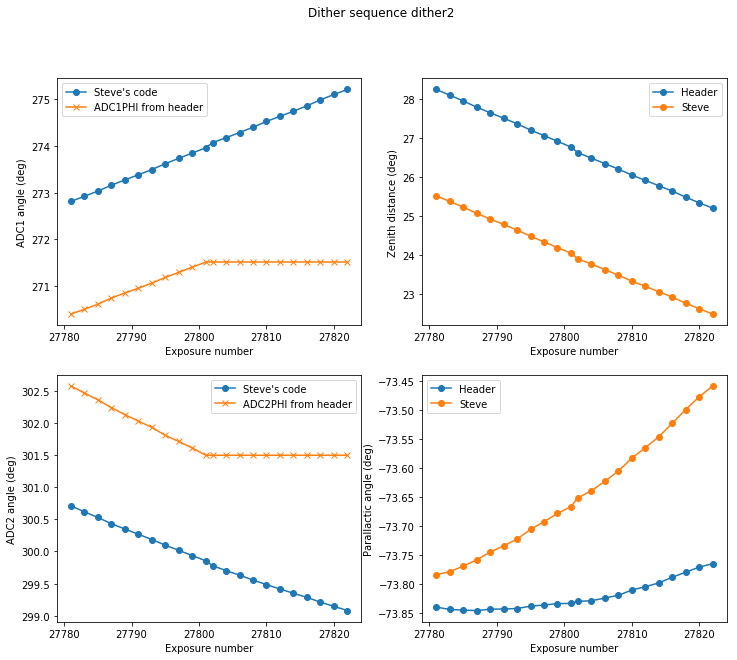

In [87]:
D = compute('dither2')
plt.plot(D.zd, D.redo_zd - D.zd, 'o-', label='Redo')
plt.plot(D.zd, D.kent_zd - D.zd, 'o-', label='Kent')
plt.ylabel('Redo ZD - ZD');
plt.show()

plt.plot(D.parallac, D.kent_parallactic - D.parallac)
plt.ylabel('Kent Parallactic - Parallactic');
plt.show()

#plt.plot(D.zd, D.zd, 'k-')
plot(D, 'dither2')

ZD 28.32913942915659 vs 28.235773
ZD 28.186069865217164 vs 28.091393
ZD 28.03937291419124 vs 27.942957
ZD 27.87776388679636 vs 27.782293
ZD 27.73458764839284 vs 27.638945
ZD 27.593241485184627 vs 27.498494
ZD 27.450044112794437 vs 27.354499
ZD 27.291399414753712 vs 27.195556
ZD 27.145323051058888 vs 27.05049
ZD 26.999623879606503 vs 26.905603
ZD 26.853554652098993 vs 26.757682
ZD 26.712294262488868 vs 26.614133
ZD 26.57624497138309 vs 26.475079
ZD 26.435545170867925 vs 26.333922
ZD 26.291740170084807 vs 26.194188
ZD 26.140057247015562 vs 26.038635
ZD 26.004196443503723 vs 25.903526
ZD 25.867523406500183 vs 25.766648
ZD 25.727212092324734 vs 25.62883
ZD 25.569308280959035 vs 25.471754
ZD 25.427409049234583 vs 25.326734
ZD 25.291335753842887 vs 25.18949


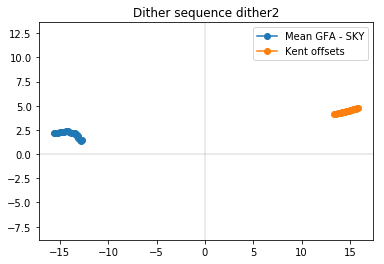

ZD 1.4202850710529304 vs 1.556381
ZD 1.5054297181368668 vs 1.65179
ZD 1.595302857044615 vs 1.744363
ZD 1.6935346974233738 vs 1.842272
ZD 1.7969411277452991 vs 1.945157
ZD 1.9032077567372738 vs 2.050982
ZD 2.029389037163824 vs 2.175387
ZD 2.1462582610607512 vs 2.291678
ZD 2.2698160246650474 vs 2.41421
ZD 2.394851942850366 vs 2.538251
ZD 2.5307642342194754 vs 2.672561
ZD 2.6393339728999194 vs 2.785976
ZD 2.7600421493020377 vs 2.903674
ZD 2.890924386904061 vs 3.032096
ZD 3.0403787334740144 vs 3.17997
ZD 3.1707727711420404 vs 3.308922
ZD 3.297517271540144 vs 3.438632
ZD 3.428250390400194 vs 3.564268
ZD 3.5579626163702187 vs 3.697442
ZD 3.704527583786529 vs 3.842119
ZD 3.8424549785521407 vs 3.975801
ZD 3.9727502713702307 vs 4.108495


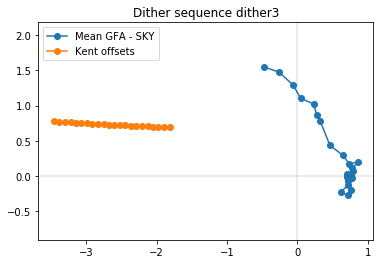

ZD 9.761394176603247 vs 9.68612
ZD 9.805369210257211 vs 9.731888
ZD 9.847091706325998 vs 9.775493
ZD 9.89090372126617 vs 9.821417
ZD 9.933402652548025 vs 9.865582
ZD 9.9833507221054 vs 9.917504
ZD 10.030637708099889 vs 9.966364
ZD 10.078130097415382 vs 10.015435
ZD 10.129861640563561 vs 10.069204
ZD 10.188982113214735 vs 10.130013
ZD 10.243758604381142 vs 10.18644
ZD 10.291256225173186 vs 10.237978
ZD 10.34596786670123 vs 10.294212
ZD 10.409533767119882 vs 10.36004
ZD 10.467862728054257 vs 10.419887
ZD 10.524830380219797 vs 10.478368
ZD 10.585201247933611 vs 10.539388
ZD 10.653806886132216 vs 10.611414
ZD 10.715276923113947 vs 10.673752
ZD 10.782657340187441 vs 10.741647
ZD 10.849235285988755 vs 10.811751
ZD 10.917783719235373 vs 10.879294


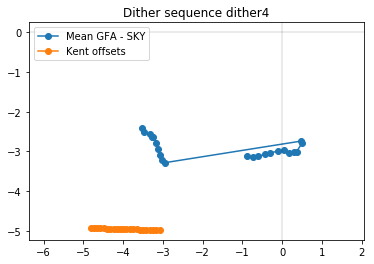

ZD 53.203103807518595 vs 53.314825
ZD 53.34501814507721 vs 53.456463
ZD 53.49204854170017 vs 53.602807
ZD 53.63836180185211 vs 53.74951
ZD 53.77617515335299 vs 53.886584
ZD 53.936677772018825 vs 54.048372
ZD 54.07997092730525 vs 54.190673
ZD 54.22688239752943 vs 54.338215
ZD 54.372950239220394 vs 54.483169
ZD 54.53851468956659 vs 54.649214
ZD 54.68037852683077 vs 54.790892
ZD 54.806806509317546 vs 54.920264
ZD 54.94186275368074 vs 55.058402
ZD 55.08646486265477 vs 55.199645
ZD 55.24629357672004 vs 55.358614
ZD 55.383224436008895 vs 55.499262
ZD 55.51955140597886 vs 55.636268
ZD 55.655556858677116 vs 55.773274
ZD 55.81372204743384 vs 55.926153
ZD 55.95854864024061 vs 56.072893
ZD 56.10381781944956 vs 56.217684
ZD 56.240508994552826 vs 56.357595


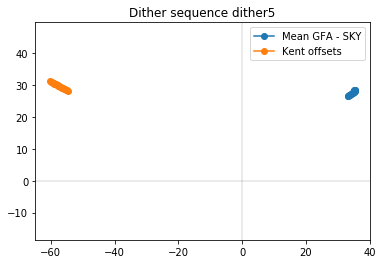

In [97]:
for dname in ['dither2', 'dither3', 'dither4', 'dither5']:
    D = compute(dname)
    cosdec = np.cos(np.deg2rad(D.sky_dec))
    dR = (D.gfa_ra  - D.sky_ra)*cosdec*3600.
    dD = (D.gfa_dec - D.sky_dec)*3600.
    plt.clf()
    plt.plot(dR, dD, 'o-', label='Mean GFA - SKY')
    plt.plot(D.xoffth * 60, D.yoffth * 60, 'o-', label='Kent offsets')
    plt.legend();
    plt.title('Dither sequence %s' % dname)
    plt.axhline(0, color='k', alpha=0.1)
    plt.axvline(0, color='k', alpha=0.1)
    plt.axis('equal')
    plt.savefig('kent-offsets-%s.png' % dname)
    plt.show()


In [31]:
site = EarthLocation.of_site('kpno')
print(site)
site = EarthLocation.from_geodetic(-111.59989 * u.deg, 31.96403 * u.deg, 2097.)
#OBS-LAT = '31.96403'           / [deg] Observatory latitude
#OBS-LONG= '-111.59989'         / [deg] Observatory east longitude
#OBS-ELEV=                2097. / [m] Observatory elevation
print(site)

(-1994502.60430614, -5037538.54232911, 3358104.99690298) m
(-1994470.69039293, -5037486.19295726, 3358158.38112224) m


In [26]:
#plt.plot(D.zd,xoffth * 60., 'o-', label='Xoffth');
#plt.plot(D.zd,yoffth * 60., 'o-', label='Yoffth');
#plt.xlabel('ZD (deg)')
#plt.ylabel('Offsets (arcsec)');

In [82]:
def plot(D, dname):
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.plot(D.expnum, D.adc1, 'o-', label="Steve's code");
    plt.plot(D.expnum, D.adc1phi, 'x-', label='ADC1PHI from header');
    plt.legend()
    plt.xlabel('Exposure number')
    plt.ylabel('ADC1 angle (deg)');

    plt.subplot(2,2,2)
    plt.plot(D.expnum, D.zd, 'o-', label='Header')
    plt.plot(D.expnum, D.kent_zd, 'o-', label='Steve')
    plt.legend()
    plt.xlabel('Exposure number')
    plt.ylabel('Zenith distance (deg)')

    plt.subplot(2,2,3)
    plt.plot(D.expnum, D.adc2, 'o-', label="Steve's code");
    plt.plot(D.expnum, D.adc2phi, 'x-', label='ADC2PHI from header');
    plt.legend()
    plt.xlabel('Exposure number')
    plt.ylabel('ADC2 angle (deg)');

    plt.subplot(2,2,4)
    plt.plot(D.expnum, D.parallac, 'o-', label='Header')
    plt.plot(D.expnum, D.kent_parallactic, 'o-', label='Steve')
    plt.legend()
    plt.xlabel('Exposure number')
    plt.ylabel('Parallactic angle (deg)')

    plt.suptitle('Dither sequence %s' % (dname));
    plt.savefig('adc-%s.png' % dname)

ZD 28.32913942915659 vs 28.235773
ZD 28.186069865217164 vs 28.091393
ZD 28.03937291419124 vs 27.942957
ZD 27.87776388679636 vs 27.782293
ZD 27.73458764839284 vs 27.638945
ZD 27.593241485184627 vs 27.498494
ZD 27.450044112794437 vs 27.354499
ZD 27.291399414753712 vs 27.195556
ZD 27.145323051058888 vs 27.05049
ZD 26.999623879606503 vs 26.905603
ZD 26.853554652098993 vs 26.757682
ZD 26.712294262488868 vs 26.614133
ZD 26.57624497138309 vs 26.475079
ZD 26.435545170867925 vs 26.333922
ZD 26.291740170084807 vs 26.194188
ZD 26.140057247015562 vs 26.038635
ZD 26.004196443503723 vs 25.903526
ZD 25.867523406500183 vs 25.766648
ZD 25.727212092324734 vs 25.62883
ZD 25.569308280959035 vs 25.471754
ZD 25.427409049234583 vs 25.326734
ZD 25.291335753842887 vs 25.18949
D expnums 27781 27822
ZD 1.4202850710529304 vs 1.556381
ZD 1.5054297181368668 vs 1.65179
ZD 1.595302857044615 vs 1.744363
ZD 1.6935346974233738 vs 1.842272
ZD 1.7969411277452991 vs 1.945157
ZD 1.9032077567372738 vs 2.050982
ZD 2.029389037

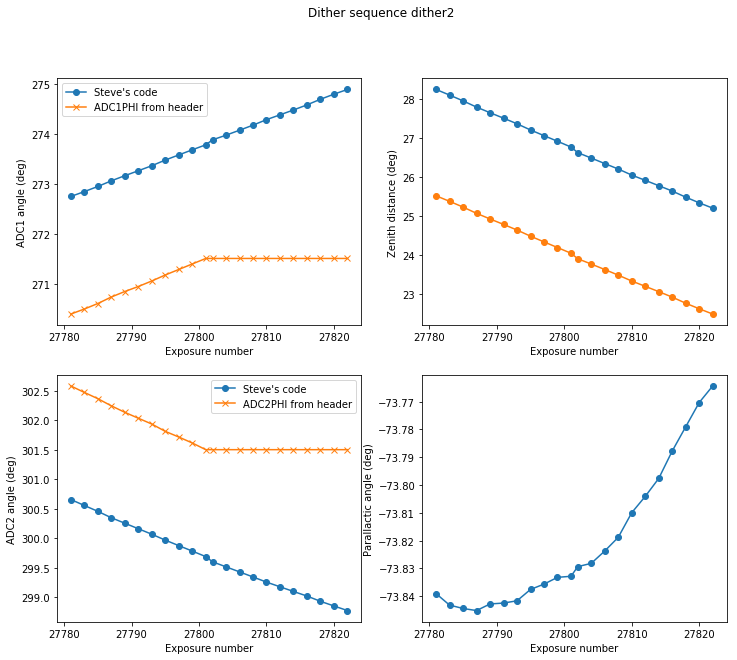

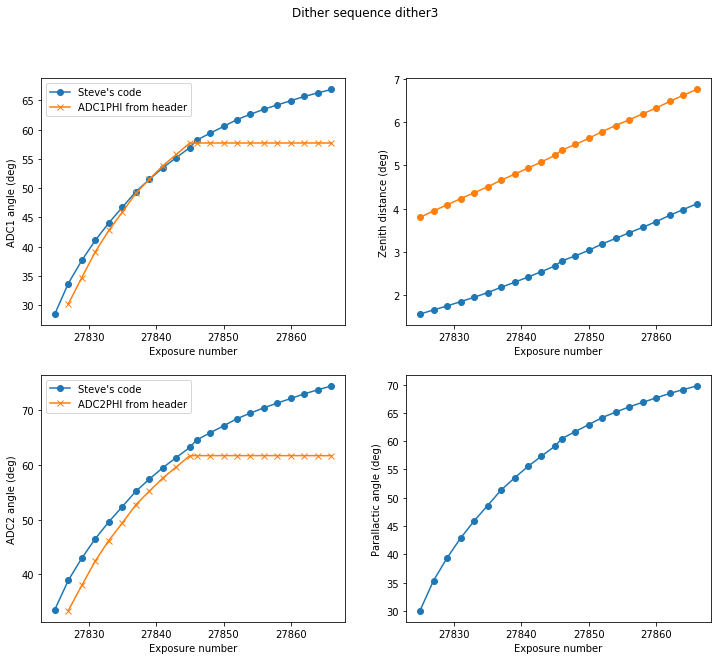

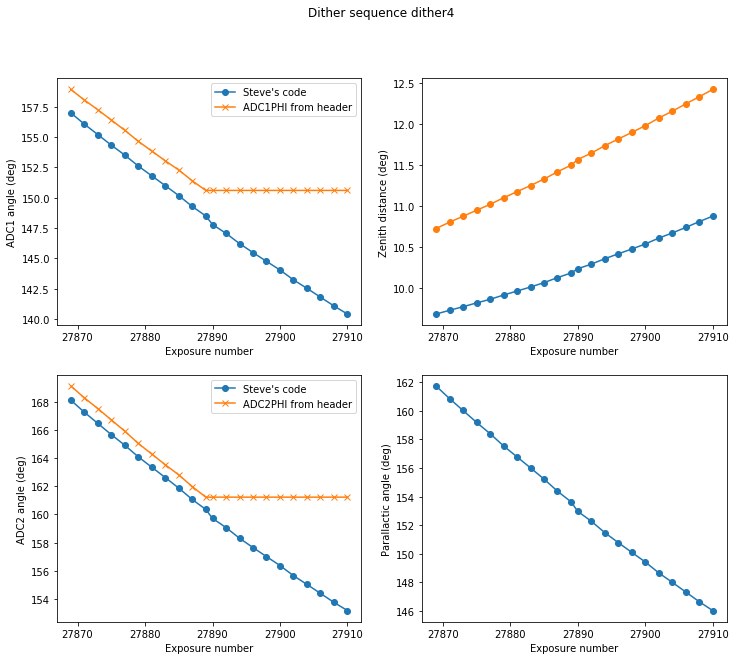

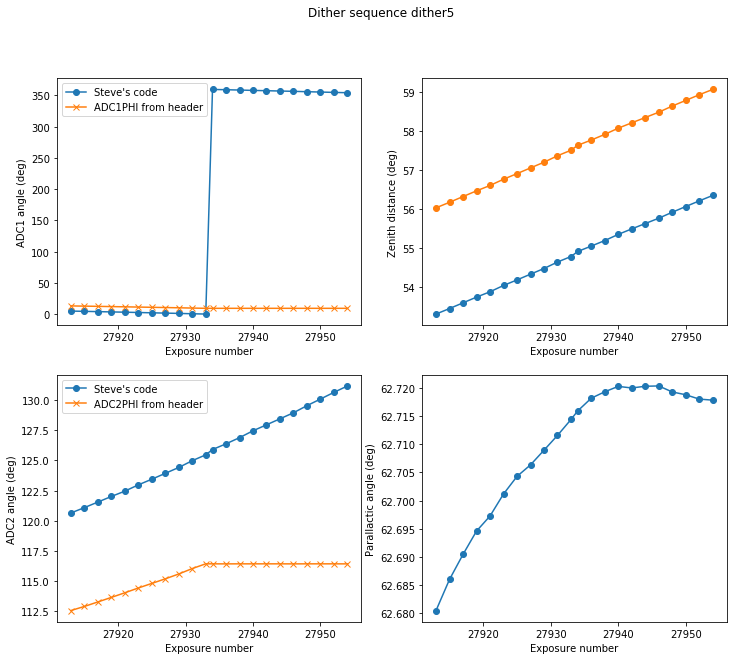

In [75]:
for dname in ['dither2', 'dither3', 'dither4', 'dither5']:
    D = compute(dname)
    print('D expnums', D.expnum.min(), D.expnum.max())
    plot(D, dname)